# Using PyTorch Lightning and MLFlow with Rockpool

## Set up task

In [1]:
import tonic
from tonic.datasets import SHD, SMNIST
from tonic import CachedDataset
from tonic.transforms import Compose, ToFrame, Downsample, NumpyAsType, NumpySqueeze, Repeat
from tonic.collation import PadTensors
from torch.utils.data import DataLoader
import torch
import numpy as np

from rockpool import TSEvent

import matplotlib.pyplot as plt

from dataclasses import dataclass, field

In [2]:
dt_sample = 1e-3
dt_snn = 10e-3

In [53]:
# - Create dataset and dataloader for Spiking Heidelberg Digits
data_transform = Compose([
    Downsample(time_factor = dt_sample, spatial_factor = 1/35),
    ToFrame((int(700 / 35), 1, 1), time_window = dt_snn / dt_sample),
    NumpySqueeze(),
    NumpyAsType(np.float32),
])

ds_train = SHD(save_to = './data', train = True, transform = data_transform)
ds_val = SHD(save_to = './data', train = False, transform = data_transform)

dl_train = DataLoader(
    ds_train,
    num_workers = 8,
    collate_fn = PadTensors(batch_first = True),
    batch_size = 64)

dl_val = DataLoader(
    ds_val,
    num_workers = 8,
    collate_fn = PadTensors(batch_first = True),
    batch_size = 64)

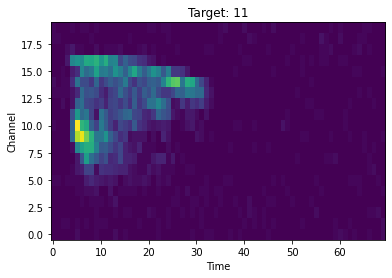

In [54]:
sample, target = ds_train[0]
plt.imshow(sample.T, aspect = 'auto', origin='lower');
plt.title(f"Target: {target}")
plt.xlabel('Time')
plt.ylabel('Channel');

In [55]:
# - Record the number of input channels
N_in = sample.shape[1]

# - Number of output classes is fixed
N_out = 20

## Define network and model

In [56]:
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

from torch.nn import functional as F

import pytorch_lightning as pl

import mlflow

In [57]:
N_hidden = 256

In [61]:
# - Define a PyTorch Lightning module
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = Sequential(
            LinearTorch((N_in, N_hidden), has_bias = False),
            LIFTorch(N_hidden, dt = dt_snn, has_bias = True, bias = 1.),
            LinearTorch((N_hidden, N_out), has_bias = False),
            LIFTorch(N_out, dt = dt_snn, has_bias = True, bias = 1.),
        ).to_torch()
    
    def forward(self, x):
        return self.net(x)
    
    def _shared_eval_step(self, batch):
        x, y = batch
        y_hat = self(x)
        y = y.unsqueeze(1).repeat(1, y_hat.shape[1])
        
        crit = F.cross_entropy(y_hat.permute(0, 2, 1), y)        
        reg = torch.mean((1 - x) ** 2)
        loss = crit + reg

        return loss
        
    def training_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [62]:
# - Instantiate the model
model = Model()

In [ ]:
# - Initialize a trainer
trainer = pl.Trainer(
    callbacks = [pl.callbacks.ModelCheckpoint()]
)

# - Enable autologging
mlflow.pytorch.autolog()

# - Create a new MLFlow run and fit the model
with mlflow.start_run() as run:
    trainer.fit(model, dl_train, dl_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2021/12/17 17:23:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.

  | Name | Type            | Params
-----------------------------------------
0 | net  | TorchSequential | 10.5 K
-----------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
sample, target = ds_train[23]
plt.plot(model(torch.from_numpy(sample.reshape(1, -1, N_in))).detach().numpy().squeeze());
plt.title(target)

In [ ]:
out, _, r_d = model.net.evolve(torch.from_numpy(sample.reshape(1, -1, N_in)), record = True)

In [ ]:
plt.imshow(r_d['0_LinearTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')

In [ ]:
plt.imshow(r_d['1_LIFTorch']['Vmem'].detach().numpy().squeeze().T, aspect='auto')

In [ ]:
plt.imshow(r_d['1_LIFTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')

In [ ]:
plt.imshow(r_d['3_LIFTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')